In [2]:
# for importing dataset 
import pandas as pd

# for Mathematics operation
import numpy as np

# matplotlib for plotting
import matplotlib.pyplot as plt

# Seaborn for pairplots
import seaborn as sns

import tensorflow as tf


from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from numpy.random import seed 
seed(0)

## Tesorboard

Tensorboard is used to display the complex and detailed architecture of our Deep Neural Network

In [3]:
from datetime import datetime
from packaging import version
 
import tensorflow as tf
import tensorboard

from tensorflow import keras
 
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above." 

print("TensorBoard version: ", tf.__version__) 

TensorFlow version:  2.4.1
TensorBoard version:  2.4.1


In [4]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
%load_ext tensorboard

## Exploratory data analysis
### Data Cleaning

In [5]:
# Importing the dataset
df_train = pd.read_csv("/content/drive/MyDrive/Assi4/COVID_dataset.csv")

In [6]:
df_train.isnull().sum()

Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

In train set there are 5 observations with missing <code>Age_Group</code> value,  9082 observations with missing <code>Outbreak_Related</code> value, 122 observations with missing <code>Specimen_Date</code> value and 203 observations with missing <code>Test_Reported_Date</code> value.

### A) Filling the missing values: 

<b>1) Dealing with <code>Outbreak_Related</code> Feature</b>

In [7]:
df_train.Outbreak_Related  = df_train.Outbreak_Related.fillna("No")

It seems that Outbreak_Related is a binary feature and takes 2 values i.e 'Yes' and 'No'. The data collected is such that the 'No' value is represented by keeping the cell(datapoint) empty. Thus, for consistency, we replace the empty cells (datapoints) in the Outbreak_Related column with "No".

<b>2) Dropping <code>Specimen_Date</code> and <code>Test_Reported_Date</code> Feature</b>



In [8]:
df_train.drop(columns=['Specimen_Date', 'Test_Reported_Date'], 
              axis=1, inplace=True)

Reason: These variables provide information about dates and have missing values which can not be replaced by any other dates.

<b>3) Dealing with <code>Age_Group</code> Feature</b>

In [9]:
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)

Here we discard observations with missing <code>Age_Group</code> values and reset indices of the data frame. 

### B) Preprocessing Data 

<b>Ordinal encoding</b> 

Here we use Ordinal encodings for <code>Age_Group</code> because the age group is an ordinal feature and takes values as below;

In [10]:
print(df_train["Age_Group"].unique())

['70s' '50s' '<20' '60s' '20s' '80s' '40s' '90s' '30s']


In [11]:
Age_Group_dict = {"<20" : 1, "20s": 2 , "30s": 3 , "40s": 4 , 
                  "50s": 5 , "60s": 6 , "70s": 7 , "80s": 8, "90s": 9}

df_train["Age_Group"] = df_train.Age_Group.map(Age_Group_dict)

Now, we create a dictionary of "key": "value" pairs, key -representing the possible values of Age_Group, -value representing the numeric value that will replace the key for a particular observation

<b>Binary Encoding</b>

<code>Client_Gender</code> and <code>Outbreak_Related</code> are  binary features so we perform Binary Encoding.

In [12]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

df_train["Client_Gender"] = lb.fit_transform(df_train["Client_Gender"])
df_train["Outbreak_Related"] = lb.fit_transform(df_train["Outbreak_Related"])

<b>One Hot Encoding</b>

<code>Case_AcquisitionInfo</code> and <code>Reporting_PHU_City</code> are Categorical features and so we perform One-Hot-Encoding.

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(df_train[["Case_AcquisitionInfo", 
                                                   "Reporting_PHU_City" ]])

encoded_feature_names = encoder.get_feature_names(["Case_AcquisitionInfo", 
                                                   "Reporting_PHU_City"])

one_hot_encoded_features = pd.DataFrame(encoded_features, columns = encoded_feature_names)

In [14]:
print("Case_AcquisitionInfo unique value:" , df_train.Case_AcquisitionInfo.nunique())

Case_AcquisitionInfo unique value: 6


In [15]:
print("Reporting_PHU_City unique value:" , df_train.Reporting_PHU_City.nunique())

Reporting_PHU_City unique value: 34


<code>Case_AcquisitionInfo</code> has 6 unique values and <code>Reporting_PHU_City</code> has 34 unique values. Performing one-hot-encoding for these 2 features will result in 6 + 34 = 40 feature columns.

In [16]:
one_hot_encoded_features.shape

(14855, 40)

<b>Label Encoding</b>

<code>Outcome1</code> is Categorical features and so we perform Label Encoding.

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["Outcome1"])
df_train["Outcome1"]  = le.transform(df_train["Outcome1"])

In [18]:
le.transform(['Fatal', 'Not Resolved', 'Resolved'])

array([0, 1, 2])

In [19]:
le.inverse_transform([0,1,2])

array(['Fatal', 'Not Resolved', 'Resolved'], dtype=object)

In [20]:
df_train = pd.concat([ df_train["Accurate_Episode_Date"],
                       df_train["Case_Reported_Date"],
                       df_train["Age_Group"],
                       df_train["Client_Gender"], 
                       df_train["Outbreak_Related"],
                       one_hot_encoded_features, 
                       df_train["Reporting_PHU_Latitude"], 
                       df_train["Reporting_PHU_Longitude"],
                       df_train["Outcome1"]], axis=1) 

In [21]:
df_train.head()

Accurate_Episode_Date Case_Reported_Date  ...  Reporting_PHU_Longitude  Outcome1
0            2020-03-30         2020-03-31  ...               -81.001913         0
1            2021-01-22         2021-01-24  ...               -79.480239         1
2            2020-03-24         2020-04-14  ...               -79.379358         2
3            2021-01-18         2021-01-21  ...               -79.708893         1
4            2020-12-26         2020-12-28  ...               -83.033670         2

[5 rows x 48 columns]

<code>Accurate_Episode_Date</code> and <code>Case_Reported_Date</code> features have a data type string which is need to be converted to float to further use these features in deep neural network. to do this, First, we removed "-" from the features and then apply them to astype(float) function. 

In [22]:
df_train["Accurate_Episode_Date"] = df_train["Accurate_Episode_Date"].str.replace("-","").astype(float)
df_train["Case_Reported_Date"] = df_train["Case_Reported_Date"].str.replace("-","").astype(float)

<b>Final dataset</b>

In [23]:
df = df_train

In [24]:
df.head()

Accurate_Episode_Date  Case_Reported_Date  ...  Reporting_PHU_Longitude  Outcome1
0             20200330.0          20200331.0  ...               -81.001913         0
1             20210122.0          20210124.0  ...               -79.480239         1
2             20200324.0          20200414.0  ...               -79.379358         2
3             20210118.0          20210121.0  ...               -79.708893         1
4             20201226.0          20201228.0  ...               -83.033670         2

[5 rows x 48 columns]

Final dataset contains 14855 observations and 48 features.

**Some Details of Outcom1 Feature**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


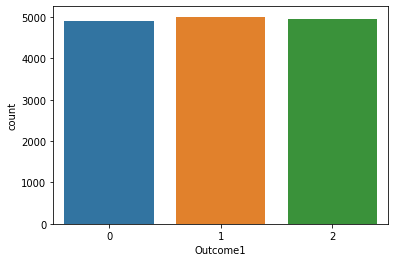

In [25]:
sns.countplot(df["Outcome1"])

In [26]:
df["Outcome1"].value_counts() / df.shape[0]

1    0.336924
2    0.333490
0    0.329586
Name: Outcome1, dtype: float64

From the above count plot we can say that the <code>outcome1</code> feature/variable is well balanced in dataset. The percentage distribution of each labels are : 

*   Fatal = 32.95%
*   Not Resolved = 33.69%
*   Resolved = 33.34%


### Spliting the data into train, validation and test set

Separating variable/features and target output. Splitting the dataset into 2 parts, 80% for training and 20%  for testing, the 20% data will be kept hidden from models and will only be used for the final model's performance analysis. This is to check how the models perform on unseen data.

In [27]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=0)

In [29]:

X_val, X_test, y_val, y_test = train_test_split(X_val_test, 
                                                y_val_test, 
                                                test_size=0.5, 
                                                random_state=0)

In [30]:
# Check dimensions of both sets.
print("Train Features Size:", X_train.shape)
print("Validation Features Size:", X_val.shape)
print("Test Features Size:", X_test.shape)

print("Train Labels Size:", y_train.shape)
print("Validation Labels Size:", y_val.shape)
print("Test Labels Size:", y_test.shape)

Train Features Size: (11884, 47)
Validation Features Size: (1485, 47)
Test Features Size: (1486, 47)
Train Labels Size: (11884,)
Validation Labels Size: (1485,)
Test Labels Size: (1486,)


### Normalizing the features

In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

When we have to deal with continuous numerical data a MinMaxScaler is most commonly used. MinMaxScaler scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset. For that reason, we used MinMaxScaler before creating a deep neural network.

## CM 1

### 1.1 Design Choices of Model


In [32]:
num_classes = 3

We took <code>num_classes</code> = 3 because we are dealing with three calss classification problem.

In [33]:
import keras

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

The reason behind this label transformation is that, we'll be using categorical crossentropy loss function for our DNN model training, and this function takes labels only when starting indexed is Zero. Thus our target variable values will range from 0 to 2.

This function returns a matrix of binary values (either ‘1’ or ‘0’). It has number of rows equal to the length of the input vector and number of columns equal to the number of classes.

  
[0] => [1, 0, 0]  
[1] => [0, 1, 0]  
[2] => [0, 0, 1]  
 


In [34]:
X_train1 = X_train
X_val1 = X_val
X_test1 = X_test

y_train1 = y_train
y_val1 = y_val



In [35]:
X_train1.shape,X_val1.shape,X_test1.shape,y_train1.shape,y_val1.shape

((11884, 47), (1485, 47), (1486, 47), (11884, 3), (1485, 3))

**Finding Best Parameter using Greed Seearch**

In [36]:
tf.random.set_seed(0)

<code>tf.random.set_seed(0)</code> is used to provide a reproducible  results.

In [37]:
def best_hyperparameters(activ,optim):

  model = Sequential()

  # 1st layer
  model.add(Dense(64, activation=activ, input_shape=(X_train1.shape)))
  model.add(Dropout(0.2))
 
  #2nd layer
  model.add(Dense(128, activation=activ))
  model.add(Dropout(0.2))

  #3rd layer
  model.add(Dense(64, activation=activ))

  #4th layer
  model.add(Dense(32, activation=activ))

  #Output layer

  model.add(Dense(3, activation='softmax'))

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
    
  return model

In [38]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

activ = ['sigmoid','relu']
optim = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=best_hyperparameters, epochs=20, batch_size=32, verbose=1)
param_grid = dict(activ=activ, optim = optim)

grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [39]:
grid_result = grid.fit(X_train1, y_train1)

Epoch 1/20
298/298 [==============================] - 1s 1ms/step - loss: 1.1068 - accuracy: 0.3330
Epoch 2/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0997 - accuracy: 0.3279
Epoch 3/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0998 - accuracy: 0.3302
Epoch 4/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0992 - accuracy: 0.3317
Epoch 5/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0992 - accuracy: 0.3358
Epoch 6/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0992 - accuracy: 0.3310
Epoch 7/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0991 - accuracy: 0.3315
Epoch 8/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0993 - accuracy: 0.3351
Epoch 9/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0994 - accuracy: 0.3352
Epoch 10/20
298/298 [==============================] - 0s 1ms/step - loss: 1.0988 - accuracy: 0.3319

In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.848452 using {'activ': 'relu', 'optim': 'Nadam'}
0.333810 (0.005798) with: {'activ': 'sigmoid', 'optim': 'SGD'}
0.845675 (0.002574) with: {'activ': 'sigmoid', 'optim': 'RMSprop'}
0.336418 (0.004485) with: {'activ': 'sigmoid', 'optim': 'Adagrad'}
0.332296 (0.003698) with: {'activ': 'sigmoid', 'optim': 'Adadelta'}
0.845339 (0.003578) with: {'activ': 'sigmoid', 'optim': 'Adam'}
0.835157 (0.006050) with: {'activ': 'sigmoid', 'optim': 'Adamax'}
0.844329 (0.005191) with: {'activ': 'sigmoid', 'optim': 'Nadam'}
0.843067 (0.004215) with: {'activ': 'relu', 'optim': 'SGD'}
0.846264 (0.003924) with: {'activ': 'relu', 'optim': 'RMSprop'}
0.802509 (0.013597) with: {'activ': 'relu', 'optim': 'Adagrad'}
0.548117 (0.091793) with: {'activ': 'relu', 'optim': 'Adadelta'}
0.846937 (0.003297) with: {'activ': 'relu', 'optim': 'Adam'}
0.845338 (0.002320) with: {'activ': 'relu', 'optim': 'Adamax'}
0.848452 (0.002223) with: {'activ': 'relu', 'optim': 'Nadam'}


Best parameters for above architecher are : **activation function** = 'relu' and **Optimizer** = 'Nadam'. Using these best parameter we developing our deep neural network.

### Building A Model 

**Model(*activation function = 'relu' Optimizer = 'Nadam'*)**

In [41]:
model_base = Sequential()

# 1st layer
model_base.add(Dense(64, input_dim=X_train1.shape[1], activation='relu'))
model_base.add(Dropout(0.2))


#2nd layer
model_base.add(Dense(128, activation='relu'))
model_base.add(Dropout(0.2))

#3rd layer
model_base.add(Dense(64, activation='relu'))

#4th layer
model_base.add(Dense(32, activation='relu'))

#Output layer

model_base.add(Dense(3, activation='softmax'))

**Model Architecture**

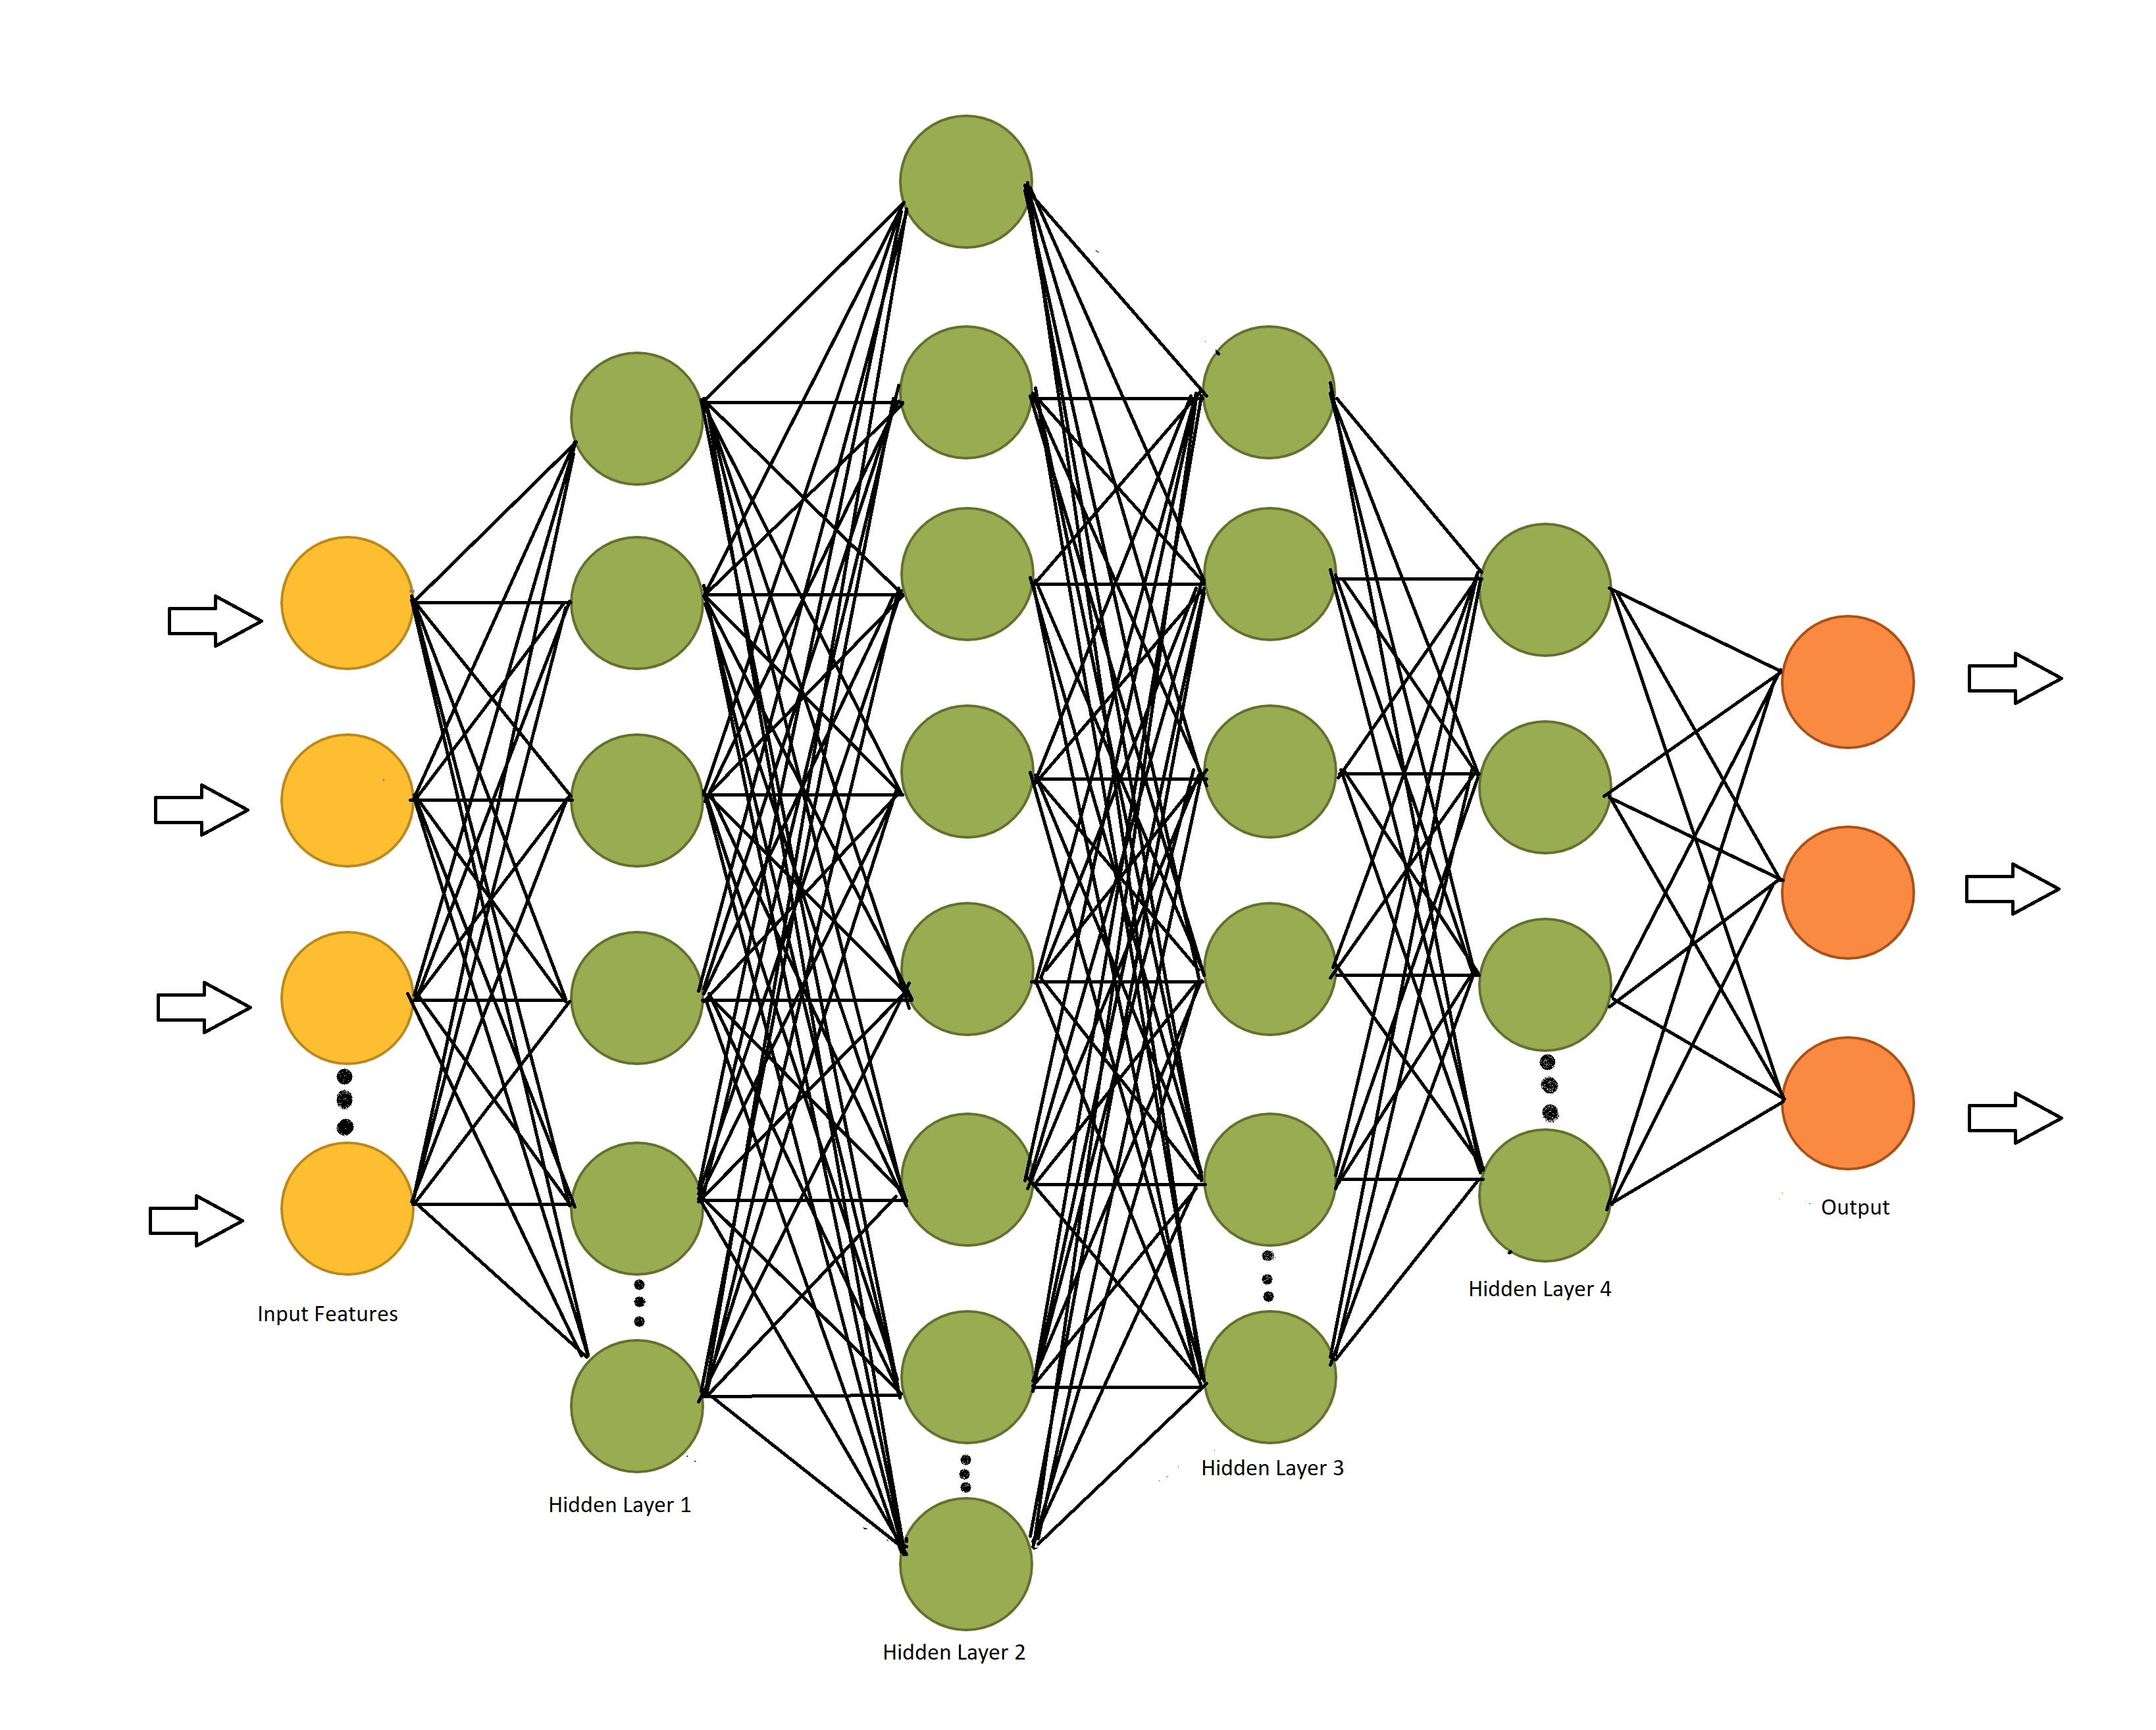

In [42]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Assi4/DNN1.png') 

The network has four hidden layers and one output layer. The hidden layer will use the relu function for activations. The output layer has three node and it is used for the prediction. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called forward propagation.

Input layer : The first layer in the neural network. It takes input signals(values) and passes them on to the next layer. It doesn’t apply any operations on the input signals(values) & has no weights and biases values associated. In our network we feed 47 features as input signals: x1, x2, x3,..,x47.

Hidden Layers: — Hidden layers have neurons(nodes) which apply different transformations to the input data. From the above image we have 4 hidden layers. In our network, first hidden layer has 64 neurons(nodes), 2nd has 128 neurons, 3rd has 64 neurons and 4th has 32 neurons. Last hidden layer passes the values to the output layer. All the neurons in a hidden layer are connected to each and every neuron in the next layer.

Output Layer — This layer is the last layer in the network & receives input from the last hidden layer. In this network we have 3 neurons in the output layer and it outputs y1, y2, y3.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called backpropagation.

**Optimizer** : *Nadam(Nesterov-accelerated Adaptive Moment Estimation)*

Adam and RMSprop(Root Mean Square Propogation) optimizers are most widely used in DNN. But, From the result of the gread search, we decide to use Nadam optimizer for our architecture.

Nadam is another version of adam. Nadam is employed for noisy gradients or for gradients with high curvatures. It is using Adam optimizer with Nesterov technique which provides a little faster training time than Adam.


**Activation function**: *Relu*
* Equation: f(x) = max(0,x)



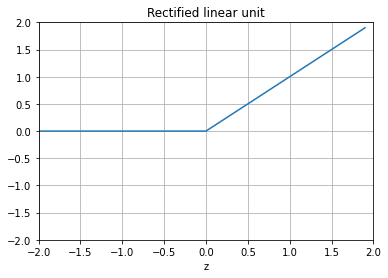

In [43]:
z = np.arange(-2, 2, .1)
zero = np.zeros(len(z))
y = np.max([zero, z], axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y)
ax.set_ylim([-2.0, 2.0])
ax.set_xlim([-2.0, 2.0])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('Rectified linear unit')

plt.show()

**Rectified linear unit(Relu)**: It is the most widely used activation function. It gives an output x if x is positive and 0 otherwise.

ReLu is non-linear, which means we can easily backpropagate the errors. ReLU function is less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations. 




**Activation function**: *SoftMax*

SoftMax fuction used on output layer which predicts a multinomial probability distribution.

**Regularization methods**

Regularization is any modification we make to a
learning algorithm that is intended to reduce its
generalization error but not its training error.

* <b>Dropout</b>: It means temporarily ignoring or deactivating neurons of the network which helps prevent overfitting. Overfitting is an error that occurs when a network is too closely fit a limited set of input samples. For our network, we used the Dropout function at the 1st and 2nd hidden layer which will drop 20% of neurons to provide a good fit of the model.


<b> Design Choice </b>

We used 4 hidden layers in our model because if we use a Shallow neural network or too few layers there may be a chance of a model to either overfit or underfit based on design. The performance of the network model may also suffer.

<!-- As per Andrew Ng “The analogy to deep learning is that the rocket engine is the deep learning models and the fuel is the huge amounts of data we can feed to these algorithms.” -->

The feature extraction and classification are automated in deep learning as compared to general ML algorithms. That's why DNN is also known as the black box. For that reason, we decide to use a Deep neural network(DNN) for this data set.  


In [44]:
print(model_base.summary())

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 64)                3072      
_________________________________________________________________
dropout_142 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_356 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_143 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_357 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_358 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_359 (Dense)            (None, 3)               

**Numbers of parameters**

The above summary provides the number of parameters calculated by the model at each level. There are 21,827 parameters in total and all of these parameters are trainable.

For exploring questions about what type of network architecture would work well on this data we decide to build two more approaches to compare with our base model.

1.   LSTM
2.   Machine learning Model(Tree-based Model)

Comparing those two with the base model gives an insight into why we choose DNN over them. 

## CM 2

### 1.2 Implementation Details

**Categorical cross entropy**

Categorical cross entropy is well suited for multi-class classification task.

The categorical crossentropy loss function calculates the loss of data by computing the following sum:
$$  Loss = - \sum_{i=1}^{output size}y_i\cdot\log \hat y_i$$ 


In [45]:
model_base.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Nadam(learning_rate=0.001),
              metrics=['accuracy'])

In [46]:
batch_size = 32
epochs = 25

<code>batch_size</code> = 32: The batch size is a hyperparameter of Nadam which controls the number of training samples to work through before the model’s internal parameters are updated.
    
<code>epochs</code> = 25:
The number of epochs is a hyperparameter of Nadam that controls the number of complete passes through the training dataset.

In [48]:
import time
tic1 = time.time()
history1 = model_base.fit(X_train1, y_train1,
          batch_size=batch_size,
          epochs=25,
          verbose=1,
          validation_data=(X_val1, y_val1),
          callbacks=[tensorboard_callback])
toc1 = time.time()
time1 = toc1-tic1

Epoch 1/25
372/372 [==============================] - 1s 2ms/step - loss: 0.4022 - accuracy: 0.8459 - val_loss: 0.3842 - val_accuracy: 0.8492
Epoch 2/25
372/372 [==============================] - 1s 2ms/step - loss: 0.3989 - accuracy: 0.8472 - val_loss: 0.3858 - val_accuracy: 0.8492
Epoch 3/25
372/372 [==============================] - 1s 2ms/step - loss: 0.3949 - accuracy: 0.8473 - val_loss: 0.4111 - val_accuracy: 0.8444
Epoch 4/25
372/372 [==============================] - 1s 3ms/step - loss: 0.3932 - accuracy: 0.8461 - val_loss: 0.3898 - val_accuracy: 0.8471
Epoch 5/25
372/372 [==============================] - 1s 2ms/step - loss: 0.3949 - accuracy: 0.8471 - val_loss: 0.3809 - val_accuracy: 0.8485
Epoch 6/25
372/372 [==============================] - 1s 2ms/step - loss: 0.3891 - accuracy: 0.8498 - val_loss: 0.3919 - val_accuracy: 0.8498
Epoch 7/25
372/372 [==============================] - 1s 2ms/step - loss: 0.3864 - accuracy: 0.8522 - val_loss: 0.3830 - val_accuracy: 0.8471
Epoch 

Here we provide an explanation of critical code block with its complex architecture.

In [49]:
%tensorboard --logdir logs

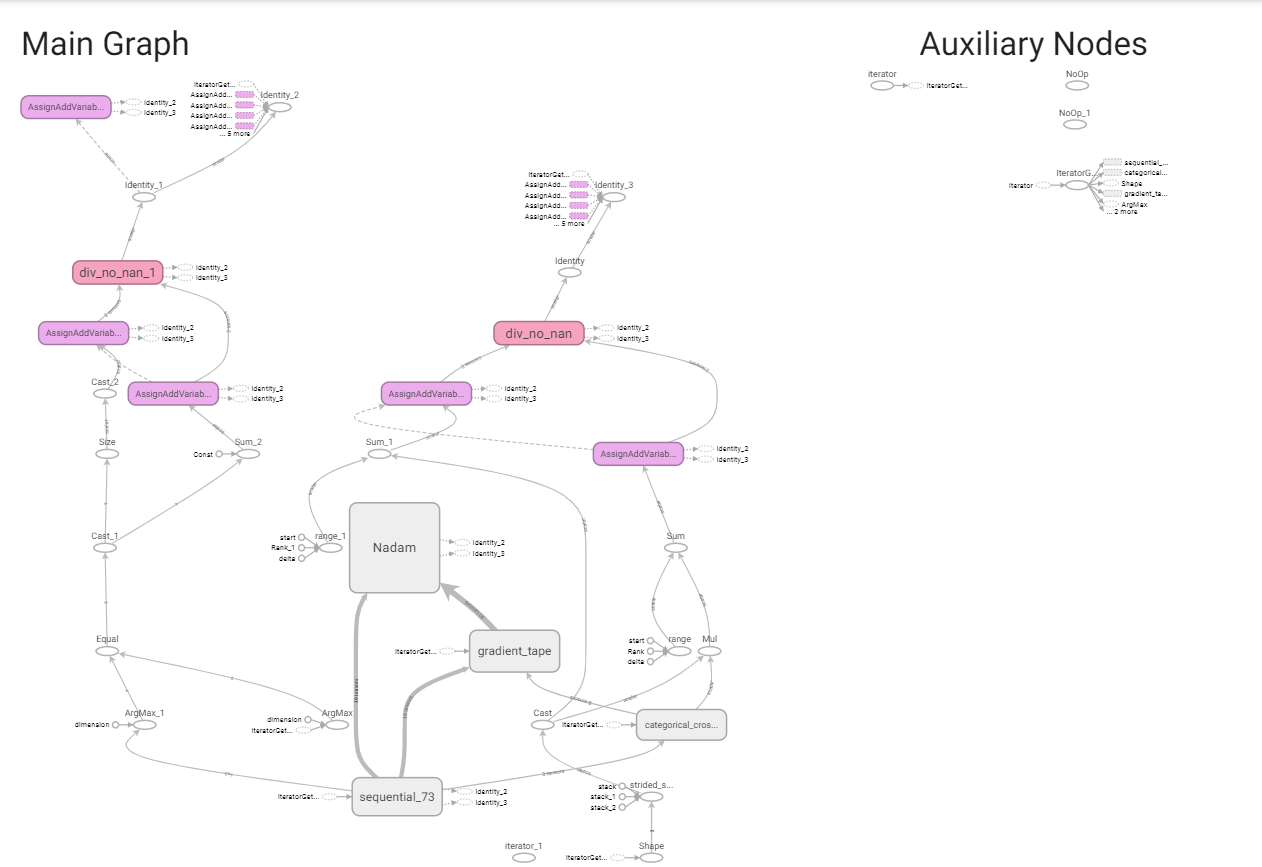

In [50]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Assi4/Screenshot (52).png') 

Here is the explanation of how we compute output. We provide a calculation of the first hidden layer which is repeated in all other hidden layers.

some key takeaways.

1. With m features in input x, we need m weights to perform a dot product.

2. With n hidden neurons in the hidden layer, we need n sets of weights (w1, w2,...,wn) for performing dot products.

3. With 1 hidden layer, we perform n dot products to get the hidden output h: (h1, h2,...,hn).

4. Then we use hidden output h: (h1, h2,..., hn) as input data that has n features, perform dot product with 1 set of n weights (w1, w2,..., wn) to get our final output y_hat.

To perform a dot product of m features in input x we need m weights.(here: w1x1 + w2x2 + ... + w47x47) and we take summation of dot product adding it to bias we get z. 
$$ z  = \sum_{i=1}^{m}w_ix_i + bias $$ 

After that, we feed z to the activation function (here: ReLu  f(z)) we get neurons of the first hidden layer (h1). Repeat this step n times (here: 4 times)) we get neurons of the last hidden layer of our model. The output of the last hidden layer feeds into the set-up function softmax to provide a final output signal.

## CM 3

### 1.3 Results Analysis

<b>Bulding a models for Comparison of the different algorithms, parameters and run time performance</b>

* Model  1: DNN + sigmoid + SGDOptimizer
* Model  2: DNN + ReLU + SGDOptimizer
* Model  3: DNN + sigmoid + AdamOptimizer   
* Model  4: DNN + ReLU + AdamOptimizer    
* Model  5: DNN + sigmoid + NadamOptimizer  
* Model  6: DNN + ReLU + NadamOptimizer    
* Model  7: DNN + sigmoid + RMSPropOptimizer    
* Model  8: DNN + ReLU + RMSPropOptimizer  
* Model  9: DNN + sigmoid + AdagradOptimizer
* Model 10: DNN + ReLU + AdagradOptimizer  
* Model 11: DNN + sigmoid + AdadeltaOptimizer 
* Model 12: DNN + ReLU + AdadeltaOptimizer  
* Model 13: DNN + sigmoid + AdamaxOptimizer 
* Model 14: DNN + ReLU + AdamaxOptimizer 
* Model 15: LSTM + ReLU + NadamOptimizer
* Model 16: LSTM + ReLU + AdamOptimizer

In [51]:
from sklearn.metrics import classification_report, accuracy_score
#Utility function to build different models
def make_model(activ_fun, optim):
  
  mode_create = Sequential()
  # Layer 1
  mode_create.add(Dense(64, input_dim=X_train1.shape[1], activation=activ_fun))
  mode_create.add(Dropout(0.2))

  # Layer 2
  mode_create.add(Dense(128, activation=activ_fun))
  mode_create.add(Dropout(0.2))

  #4th layer
  mode_create.add(Dense(32, activation=activ_fun))

  #Output layer
  mode_create.add(Dense(3, activation='softmax'))

  import time

  opt = None
  if optim =='SGD':
    opt = keras.optimizers.SGD(lr=0.01)
  if optim =='Adam':
    opt = keras.optimizers.Adam(learning_rate=0.001)
  if optim =='Nadam':
    opt = keras.optimizers.Nadam(learning_rate=0.001)
  if optim =='RMSprop':
    opt = keras.optimizers.RMSprop(learning_rate=0.001)
  if optim =='Adagrad':
    opt = keras.optimizers.Adagrad(learning_rate=0.001)
  if optim =='Adadelta':
    opt = keras.optimizers.Adadelta(learning_rate=0.001)
  if optim =='Adamax':
    opt = keras.optimizers.Adamax(learning_rate=0.001)
  else:
    opt = opt

  mode_create.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  tic = time.time()
  history = mode_create.fit(X_train1, y_train1,
            batch_size=32,
            epochs=25,
            verbose=0,
            validation_data=(X_val1, y_val1)
            )
  toc = time.time()

  tic_f = time.time()
  score = mode_create.evaluate(X_val1, y_val1, verbose=0)
  toc_f = time.time()

  return (mode_create, history, toc-tic, score, toc_f-tic_f)

In [52]:
model1 = make_model('sigmoid', 'SGD')

print("Model 1: CNN + Sigmoid + SGDOptimizer")
print("Train accuracy:", round(model1[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model1[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model1[2], 2), 'Sec')
print('Test loss:', round(model1[3][0], 2))
print('Test accuracy:',round(model1[3][1],2)*100)
print("Test time:", round(model1[4], 2), 'Sec')

Model 1: CNN + Sigmoid + SGDOptimizer
Train accuracy: 52.0
Validation accuracy: 61.0
Training time: 11.29 Sec
Test loss: 0.99
Test accuracy: 61.0
Test time: 0.07 Sec


In [53]:
model2 = make_model('relu', 'SGD')

print("Model 2: DNN + ReLU + SGDOptimizer")
print("Train accuracy:", round(model2[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model2[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model2[2], 2), 'Sec')
print('Test loss:', round(model2[3][0], 2))
print('Test accuracy:',round(model2[3][1],2)*100)
print("Test time:", round(model2[4], 2), 'Sec')

Model 2: DNN + ReLU + SGDOptimizer
Train accuracy: 84.0
Validation accuracy: 85.0
Training time: 11.12 Sec
Test loss: 0.39
Test accuracy: 85.0
Test time: 0.07 Sec


In [54]:
model3 = make_model('sigmoid', 'Adam')

print("Model 3: DNN + Sigmoid + AdamOptimizer")
print("Train accuracy:", round(model3[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model3[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model3[2], 2), 'Sec')
print('Test loss:', round(model3[3][0], 2))
print('Test accuracy:',round(model3[3][1],2)*100)
print("Test time:", round(model3[4], 2), 'Sec')

Model 3: DNN + Sigmoid + AdamOptimizer
Train accuracy: 84.0
Validation accuracy: 84.0
Training time: 13.94 Sec
Test loss: 0.39
Test accuracy: 84.0
Test time: 0.08 Sec


In [55]:
model4 = make_model('relu', 'Adam')

print("Model 4: DNN + ReLU + AdamOptimizer ")
print("Train accuracy:", round(model4[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model4[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model4[2], 2), 'Sec')
print('Test loss:', round(model4[3][0], 2))
print('Test accuracy:',round(model4[3][1],2)*100)
print("Test time:", round(model4[4], 2), 'Sec')

Model 4: DNN + ReLU + AdamOptimizer 
Train accuracy: 85.0
Validation accuracy: 85.0
Training time: 14.21 Sec
Test loss: 0.39
Test accuracy: 85.0
Test time: 0.07 Sec


In [56]:
model5 = make_model('sigmoid', 'Nadam')

print("Model 5: DNN + Sigmoid + NadamOptimizer ")
print("Train accuracy:", round(model5[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model5[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model5[2], 2), 'Sec')
print('Test loss:', round(model5[3][0], 2))
print('Test accuracy:',round(model5[3][1],2)*100)
print("Test time:", round(model5[4], 2), 'Sec')

Model 5: DNN + Sigmoid + NadamOptimizer 
Train accuracy: 84.0
Validation accuracy: 84.0
Training time: 13.6 Sec
Test loss: 0.38
Test accuracy: 84.0
Test time: 0.07 Sec


In [57]:
model6 = make_model('relu', 'Nadam')

print("Model 6: DNN + ReLU + NadamOptimizer ")
print("Train accuracy:", round(model6[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model6[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model6[2], 2), 'Sec')
print('Test loss:', round(model6[3][0], 2))
print('Test accuracy:',round(model6[3][1],2)*100)
print("Test time:", round(model6[4], 2), 'Sec')

Model 6: DNN + ReLU + NadamOptimizer 
Train accuracy: 86.0
Validation accuracy: 85.0
Training time: 13.42 Sec
Test loss: 0.39
Test accuracy: 85.0
Test time: 0.07 Sec


In [58]:
model7 = make_model('sigmoid', 'RMSprop')

print("Model 7: DNN + Sigmoid + RMSPropOptimizer ")
print("Train accuracy:", round(model7[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model7[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model7[2], 2), 'Sec')
print('Test loss:', round(model7[3][0], 2))
print('Test accuracy:',round(model7[3][1],2)*100)
print("Test time:", round(model7[4], 2), 'Sec')

Model 7: DNN + Sigmoid + RMSPropOptimizer 
Train accuracy: 84.0
Validation accuracy: 84.0
Training time: 12.36 Sec
Test loss: 0.39
Test accuracy: 84.0
Test time: 0.08 Sec


In [59]:
model8 = make_model('relu', 'RMSprop')

print("Model 8: DNN + ReLU + RMSPropOptimizer")
print("Train accuracy:", round(model8[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model8[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model8[2], 2), 'Sec')
print('Test loss:', round(model8[3][0], 2))
print('Test accuracy:',round(model8[3][1],2)*100)
print("Test time:", round(model8[4], 2), 'Sec')

Model 8: DNN + ReLU + RMSPropOptimizer
Train accuracy: 85.0
Validation accuracy: 85.0
Training time: 12.51 Sec
Test loss: 0.4
Test accuracy: 85.0
Test time: 0.07 Sec


In [60]:
model9 = make_model('sigmoid', 'Adagrad')

print("Model 9: DNN + Sigmoid + AdagradOptimizer")
print("Train accuracy:", round(model9[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model9[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model9[2], 2), 'Sec')
print('Test loss:', round(model9[3][0], 2))
print('Test accuracy:',round(model9[3][1],2)*100)
print("Test time:", round(model9[4], 2), 'Sec')

Model 9: DNN + Sigmoid + AdagradOptimizer
Train accuracy: 35.0
Validation accuracy: 33.0
Training time: 11.54 Sec
Test loss: 1.09
Test accuracy: 33.0
Test time: 0.08 Sec


In [61]:
model10 = make_model('relu', 'Adagrad')

print("Model 10: DNN + ReLU + AdagradOptimizer")
print("Train accuracy:", round(model10[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model10[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model10[2], 2), 'Sec')
print('Test loss:', round(model10[3][0], 2))
print('Test accuracy:',round(model10[3][1],2)*100)
print("Test time:", round(model10[4], 2), 'Sec')

Model 10: DNN + ReLU + AdagradOptimizer
Train accuracy: 79.0
Validation accuracy: 81.0
Training time: 11.41 Sec
Test loss: 0.49
Test accuracy: 81.0
Test time: 0.07 Sec


In [62]:
model11 = make_model('sigmoid', 'Adadelta')

print("Model 11: DNN + Sigmoid + AdadeltaOptimizer ")
print("Train accuracy:", round(model11[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model11[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model11[2], 2), 'Sec')
print('Test loss:', round(model11[3][0], 2))
print('Test accuracy:',round(model11[3][1],2)*100)
print("Test time:", round(model11[4], 2), 'Sec')

Model 11: DNN + Sigmoid + AdadeltaOptimizer 
Train accuracy: 32.0
Validation accuracy: 33.0
Training time: 11.76 Sec
Test loss: 1.1
Test accuracy: 33.0
Test time: 0.08 Sec


In [63]:
model12 = make_model('relu', 'Adadelta')

print("Model 12: DNN + ReLU + AdadeltaOptimizer ")
print("Train accuracy:", round(model12[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model12[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model12[2], 2), 'Sec')
print('Test loss:', round(model12[3][0], 2))
print('Test accuracy:',round(model12[3][1],2)*100)
print("Test time:", round(model12[4], 2), 'Sec')

Model 12: DNN + ReLU + AdadeltaOptimizer 
Train accuracy: 56.99999999999999
Validation accuracy: 66.0
Training time: 11.72 Sec
Test loss: 1.0
Test accuracy: 66.0
Test time: 0.07 Sec


In [64]:
model13 = make_model('sigmoid', 'Adamax')

print("Model 13: DNN + Sigmoid + AdamaxOptimizer ")
print("Train accuracy:", round(model13[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model13[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model13[2], 2), 'Sec')
print('Test loss:', round(model13[3][0], 2))
print('Test accuracy:',round(model13[3][1],2)*100)
print("Test time:", round(model13[4], 2), 'Sec')

Model 13: DNN + Sigmoid + AdamaxOptimizer 
Train accuracy: 83.0
Validation accuracy: 84.0
Training time: 11.83 Sec
Test loss: 0.4
Test accuracy: 84.0
Test time: 0.07 Sec


In [65]:
model14 = make_model('relu', 'Adamax')

print("Model 14: DNN + ReLU + AdamaxOptimizer ")
print("Train accuracy:", round(model14[1].history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(model14[1].history['val_accuracy'][-1], 2)*100)
print("Training time:", round(model14[2], 2), 'Sec')
print('Test loss:', round(model14[3][0], 2))
print('Test accuracy:',round(model14[3][1],2)*100)
print("Test time:", round(model14[4], 2), 'Sec')

Model 14: DNN + ReLU + AdamaxOptimizer 
Train accuracy: 85.0
Validation accuracy: 85.0
Training time: 11.85 Sec
Test loss: 0.39
Test accuracy: 85.0
Test time: 0.07 Sec


#### LSTM

LSTM(Long Short Term Memory) is another form of RNN(Recurrent Neural Network) which is used to overcome the limitation of RNN. LSTM learns long term dependencies by replacing the hidden layers of RNN with memory cells. Different gate units such as input gate (it), output gate (ot), forget gate (ft) along with the activation function are used to model LSTMs and learn the behavior of temporal correlations. 

Here we used Stacked LSTM which is also known as multilayer fully connected structure with multiple LSTM layers resulting stack like architecture. Combining multiple LSTM layers leads to greater model complexity and increased depth of the model. Each intermediate LSTM layer outputs resulting sequential vectors that are used as an input for next LSTM layer. Stacked LSTM provides output for each time stamp and not the single output for all time stamps.

In [66]:
#Convert to numpy arrays
X_train3 = np.array(X_train)
X_val3 = np.array(X_val)
X_test3 = np.array(X_test)

#Reshape the data into 3-D array
X_train3 = np.reshape(X_train3, (X_train3.shape[0],X_train3.shape[1],1))
X_val3 = np.reshape(X_val3, (X_val3.shape[0],X_val3.shape[1],1))
X_test3 = np.reshape(X_test3, (X_test3.shape[0],X_test3.shape[1],1))

#Print Shape

X_train3.shape, X_test3.shape, X_val3.shape

((11884, 47, 1), (1486, 47, 1), (1485, 47, 1))

The reason behind transforming our 2D data in 3D is that LSTM took input shape in the third dimension.

In [67]:
# convert class vectors to binary class matrices
y_train3 = y_train
#y_test = np.array(keras.utils.to_categorical(y_test,3))
y_val3 = y_val
#test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [68]:
tf.random.set_seed(0)

In [87]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (X_train3.shape[1],
                                                                                                     X_train3.shape[2])))
model_LSTM.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model_LSTM.add(Dense(3, activation='softmax'))

In [88]:
model_LSTM.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 47, 128)           66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_417 (Dense)            (None, 3)                 195       
Total params: 116,163
Trainable params: 116,163
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_LSTM.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(learning_rate=0.001),
              metrics=['accuracy'])

In [90]:
import time
tic2 = time.time()
history2 = model_LSTM.fit(X_train3, y_train3,
          batch_size=32,
          epochs=25,
          verbose=1,
          validation_data=(X_val3, y_val3))
toc2 = time.time()

Epoch 1/25
372/372 [==============================] - 79s 196ms/step - loss: 1.0570 - accuracy: 0.4051 - val_loss: 0.6877 - val_accuracy: 0.6963
Epoch 2/25
372/372 [==============================] - 73s 197ms/step - loss: 0.7259 - accuracy: 0.6810 - val_loss: 0.6825 - val_accuracy: 0.7024
Epoch 3/25
372/372 [==============================] - 74s 199ms/step - loss: 0.6930 - accuracy: 0.6937 - val_loss: 0.7189 - val_accuracy: 0.6862
Epoch 4/25
372/372 [==============================] - 74s 200ms/step - loss: 0.7096 - accuracy: 0.6793 - val_loss: 0.6444 - val_accuracy: 0.6949
Epoch 5/25
372/372 [==============================] - 73s 197ms/step - loss: 0.6829 - accuracy: 0.6908 - val_loss: 0.6270 - val_accuracy: 0.7266
Epoch 6/25
372/372 [==============================] - 73s 196ms/step - loss: 0.6973 - accuracy: 0.6924 - val_loss: 0.6421 - val_accuracy: 0.7387
Epoch 7/25
372/372 [==============================] - 73s 197ms/step - loss: 0.6769 - accuracy: 0.7032 - val_loss: 0.6470 - val_ac

In [91]:
print("Train accuracy:", round(history2.history['accuracy'][-1], 2)*100)
print("Validation accuracy:", round(history2.history['val_accuracy'][-1], 2)*100)

Train accuracy: 81.0
Validation accuracy: 81.0


In [92]:
import time
tic21 = time.time()
score2 = model_LSTM.evaluate(X_val3, y_val3, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
toc21 = time.time()


Test loss: 0.4599013924598694
Test accuracy: 0.8141413927078247


In [93]:
time21 = toc21-tic21
time2 = toc2 - tic2

print("Training time:", round(time2, 2), 'Sec')
print("Test time:", round(time21, 2), 'Sec')

Training time: 1832.37 Sec
Test time: 0.96 Sec


**Run Time comparison with Tree based model**

#### 1. Random Forest 

In [97]:
param_dict = {"n_estimators": [5, 10, 50, 150, 200], 
              "max_depth": [3, 5, 10, 15,25] }

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

grid_RF = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), 
                    param_grid = param_dict,
                    cv = 10,
                    verbose = 1)

We are using <code>GridSearchCV</code> method from sklearn's <code>model_selection</code> package. The grid object accepts following paramenters;
<ol>
<li>
<code>estimator</code> : the Classifier we are trying to find best hyper parameters for.
</li>
<li>
<code>param_grid</code> : a dictionary of hyper parameters for the classifier.
</li>
<li>
<code>cv</code> : Split dataset into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
</li>
<li>
<code>verbose</code> : Controls the verbosity; the higher, the more messages.
</li>
</ol>

In [99]:
import time

tic3 = time.time()

grid_RF.fit(X_train1, y_train1)

toc3 = time.time()
time3 = toc3-tic3

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.1min finished


In [100]:
grid_RF.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [101]:
grid_RF.best_score_

0.9146764108706916

#### 2. Decision Tree

In [102]:
param_dict1 = {"max_depth": [3, 5, 10, 15,25] }

In [103]:
from sklearn.tree import DecisionTreeClassifier

grid_DT = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0), 
                    param_grid = param_dict1,
                    cv = 10,
                    verbose = 1)




We are using <code>GridSearchCV</code> method from sklearn's <code>model_selection</code> package. The grid object accepts following paramenters;
<ol>
<li>
<code>estimator</code> : the Classifier we are trying to find best hyper parameters for.
</li>
<li>
<code>param_grid</code> : a dictionary of hyper parameters for the classifier.
</li>
<li>
<code>cv</code> : Split dataset into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
</li>
<li>
<code>verbose</code> : Controls the verbosity; the higher, the more messages.
</li>
</ol>

In [104]:
import time

tic4 = time.time()

grid_DT.fit(X_train1, y_train1)

toc4 = time.time()
time4 = toc4-tic4

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished


In [105]:
grid_DT.best_params_

{'max_depth': 5}

In [106]:
grid_DT.best_score_

0.916275454290593

In [107]:
time3 = toc3-tic3
time4 = toc4-tic4

In [108]:
data_DNN = {"algo": ["DNN"],
           "time_elapsed": time1}

data_LSTM =  {"algo": ["LSTM"],
           "time_elapsed": time2}

data_RF =  {"algo": ["RF"],
           "time_elapsed": time3}

data_DT =  {"algo": ["DT"],
           "time_elapsed": time4}


In [109]:
df_DNN =  pd.DataFrame(data_DNN)
df_LSTM =  pd.DataFrame(data_LSTM)
decision_tree_DT =  pd.DataFrame(data_DT)
decision_tree_RF =  pd.DataFrame(data_RF)


DF  = pd.concat([df_DNN, df_LSTM, decision_tree_RF, decision_tree_DT])

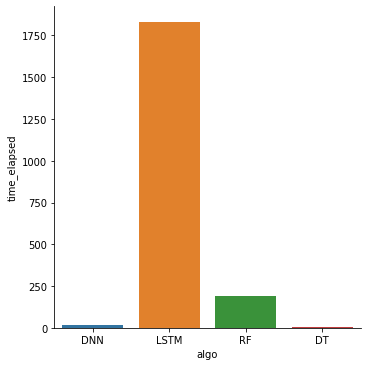

In [110]:
import seaborn as sns
plot = sns.catplot(y="time_elapsed", x="algo", kind="bar", data=DF)

From the above bar plot we can see that the Decision tree model takes the least amount of time to train where as LSTM takes almost 28 minutes(1600 sec) to train yet provides least accuracy compare to Decision tree.

Random forest model which is based on collection of multiple trees as expected takes more time than a single decision tree model.

Our DNN model takes least time compare to LSTM and Random Forest. The accuracy of DNN (84%) less as compared to Decision tree and Random Forest provides (90%) which can be improved by tuning hyper parameter more carefully.




<b>Plots</b>

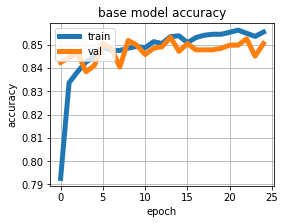

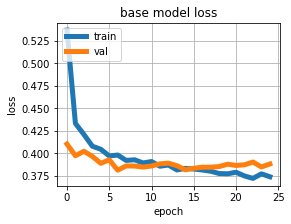

In [136]:
# Plot the model accuracy vs. number of Epochs


plt.figure(figsize=(4, 3))
plt.grid()
plt.plot(model6[1].history['accuracy'], linewidth=5)
plt.plot(model6[1].history['val_accuracy'], linewidth=5)
plt.title('base model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the model loss vs. number of Epochs
plt.figure(figsize=(4, 3))
plt.grid()
plt.plot(model6[1].history['loss'], linewidth=5)
plt.plot(model6[1].history['val_loss'], linewidth=5)
plt.title('base model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the train-validation accuracy Vs. Epoch graph, During the epochs (1-10) the training accuracy and validation accuracy increase after that the accuracies seems to plateau.The training graph is quite smooth while the validation graph follow ups and downs, which can be smoothened by optimizing batch_size of the model.

From the loss Vs. epoch graph it is visible that the training and validation losses does reduce during the whole process which is a good sign for model training. The validation loss plateaus after about 10 epochs.

<b>Evalution with other metrics</b>

In [137]:
y_pred1 = np.argmax(model_base.predict(X_test1), axis=1)

In [138]:
from sklearn.metrics import confusion_matrix, classification_report
model_accuracy1 = accuracy_score(y_test, y_pred1)*100
print("Model Accracy:", model_accuracy1,"%")
print(classification_report(y_test, y_pred1))

Model Accracy: 84.45491251682368 %
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       473
           1       0.80      0.96      0.87       511
           2       0.96      0.66      0.78       502

    accuracy                           0.84      1486
   macro avg       0.86      0.85      0.84      1486
weighted avg       0.86      0.84      0.84      1486



<b>Precision</b>:
* Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
* <code>Precision = TP/TP+FP</code>
* For <code>Resovled cases</code> we used precision matrix which shows that model accurately predict these cases with 96% precision.


<b>Recall (Sensitivity)</b>:
* Recall is the ratio of correctly predicted positive observations to the all observations in actual class 
* <code>Recall = TP/TP+FN</code>
* For <code>Not Resovled cases</code> we used recall matric which shows that model lessly missing any positievs with 96% recall.

<b>F1 score</b>:
* F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
* <code>F1 Score = 2*(Recall * Precision) / (Recall + Precision)</code>

From the above classification report we can say that model have overall 84% accuracy on test set. From F1 score we can interpret that model predicted Fatal cases (F1 score : 0.87) and Not Resolved (F2 score : 0.87) case well. It slightly struggles to predict Resovled cases.

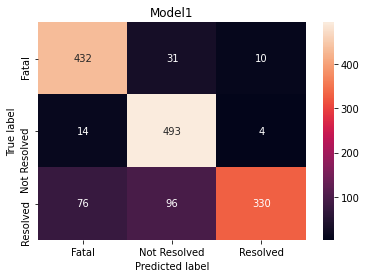

In [139]:
from sklearn.metrics import confusion_matrix, classification_report

outcome1 = ['Fatal', 'Not Resolved', 'Resolved']

cm = confusion_matrix(y_test, y_pred1)
df_cm = pd.DataFrame(cm, index=outcome1, columns=outcome1)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Model1');

From the above matrix we can say that most of the numbers lie on diagonal line which means the model does a good job at trying and predicting every class correctly.  